In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [3]:
df = pd.read_csv("../CSVFiles/small50000DomainDataBertweetEmbedded.csv")

In [4]:
df = df.loc[:, ["comment_text", "split", "toxicity", "male", "female", "LGBTQ", "christian", "muslim", "other_religion", "black", "white"]]
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

df['toxicity'] = df['toxicity'].apply(lambda text: np.round(text >= 0.5))
df['male'] = df['male'].apply(lambda x: np.round(x>=0.5))
df['female'] = df['female'].apply(lambda x: np.round(x>=0.5))
df['LGBTQ'] = df['LGBTQ'].apply(lambda x: np.round(x>=0.5))
df['christian'] = df['christian'].apply(lambda x: np.round(x>=0.5))
df['muslim'] = df['muslim'].apply(lambda x: np.round(x>=0.5))
df['other_religion'] = df['other_religion'].apply(lambda x: np.round(x>=0.5))
df['black'] = df['black'].apply(lambda x: np.round(x>=0.5))
df['white'] = df['white'].apply(lambda x: np.round(x>=0.5))

In [5]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [6]:
X_train = training_data['comment_text'].values.tolist()
Y_train = training_data['toxicity'].values.tolist()

X_test = test_data['comment_text'].values.tolist()
Y_test = test_data['toxicity'].values.tolist()

X_val = validation_data['comment_text'].values.tolist()
Y_val = validation_data['toxicity'].values.tolist()

In [7]:
class AdalineGDFair():
    def __init__(self, learning_rate = 0.01, n_iter = 20, w = None):
        self.w = w
        self.bestW = None
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        
    def CheckAccuracy(self, predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (np.round(predictions[i]) == np.round(labels[i])):
                acc += 1
        return acc/len(predictions)
    
    def predict(self, X_test):
        # Making sure that array is numpy array
        X_test = np.array(X_test).reshape((len(X_test), -1))
        output = np.dot(X_test, self.w)
        # Sigmoid giving 0-1 results
        preds = np.round(1/(1+np.exp(-output)))
        return preds
    
    def PredictTestSetDemographic(self, dfTest):
        dic = {}
        for col in dfTest.columns[3:]:
            tempSet = dfTest[dfTest[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dic[col] = [tempVecs, tempLabels]
        
        f1_scores = []
        for col in dic:
            tempPredictions = self.predict(dic[col][0])
            currentF1 = f1_score(dic[col][1], tempPredictions, zero_division=1)
            f1_scores.append([currentF1, col])
        
        f1_scores = np.array(f1_scores)
        return f1_scores
    
        
    def fit(self, dfTrain, dfVal):
        # Making sure that arrays are numpy arrays
        
        X_train = dfTrain['comment_text'].values.tolist()
        Y_train = dfTrain['toxicity'].values.tolist()
        
        X_train = np.array(X_train).reshape((len(X_train), -1))
        Y_train = np.array(Y_train).reshape((len(Y_train), 1))
        
        X_val = dfVal['comment_text'].values.tolist()
        Y_val = dfVal['toxicity'].values.tolist()
        
        X_val = np.array(X_val).reshape((len(X_val), -1))
        Y_val = np.array(Y_val).reshape((len(Y_val), 1))
        
        # Initializing w vector using random normal distribution
        if self.w == None:
            self.w = np.random.normal(0, 0.1, len(X_train[0])).reshape(len(X_train[0]), 1)
        
        # Updating w vector for each sample
        output = 1/(1+np.exp(-np.dot(X_train, self.w)))
        error = (Y_train - output)
        self.w += (1/len(Y_train)) * self.learning_rate * np.dot(X_train.T, error)
        
        dicTrain = {}
        # AFHÆNGER AF HVOR MANGE DEMOGRAFISKE VARIABLER DER HAVES: 
        for col in dfTrain.columns[3:]:
            tempSet = dfTrain[dfTrain[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dicTrain[col] = [tempVecs, tempLabels]
            
        dicVal = {}
        # AFHÆNGER AF HVOR MANGE DEMOGRAFISKE VARIABLER DER HAVES: 
        for col in dfVal.columns[3:]:
            tempSet = dfVal[dfVal[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dicVal[col] = [tempVecs, tempLabels]
        
        valPreds = self.predict(X_val)
        bestAcc = self.CheckAccuracy(valPreds, Y_val)

        badEpoch = 0
        self.bestW = self.w
        early_stopping = 200
        
        self.FinalAccList_ = []
        self.FinalAccListTrain_ = []
        
        # Using n epochs
        for i in range(self.n_iter):
            f1_scores = []
            for col in dicVal:
                tempPredictions = self.predict(dicVal[col][0])
                currentF1 = f1_score(dicVal[col][1], tempPredictions, zero_division=1)
                f1_scores.append([currentF1, col])
            f1_scores = np.array(f1_scores)        
            
            if i == 0:
                print(f1_scores)
            
            worstCol = f1_scores[np.argmin(f1_scores[:,0])][1]
                        
            X_train = dicTrain[worstCol][0]
            Y_train = dicTrain[worstCol][1]
            
            X_train = np.array(X_train).reshape((len(X_train), -1))
            Y_train = np.array(Y_train).reshape((len(Y_train), 1))
            
            # Updating w vector for each sample
            output = 1/(1+np.exp(-np.dot(X_train, self.w)))
            error = (Y_train - output)
            self.w += (1/len(Y_train)) * self.learning_rate * np.dot(X_train.T, error)
            
            valPreds = self.predict(X_val)
            acc = self.CheckAccuracy(valPreds, Y_val)
            self.FinalAccList_.append((acc, worstCol, i))
            
            trainPreds = self.predict(X_train)
            acc = self.CheckAccuracy(trainPreds, Y_train)
            self.FinalAccListTrain_.append((acc, worstCol, i))
                        
            # Saving the best model and also checks for Early_Stopping
            if acc > bestAcc:
                bestAcc = acc
                badEpoch = 0
                self.bestW = self.w
            else:
                badEpoch += 1

            if badEpoch >= early_stopping:
                self.w = self.bestW
                print("Stopped cause of bad Epoch in iteration: ", i)
                break
                
        self.FinalAccList_ = np.array(self.FinalAccList_)
        self.FinalAccListTrain_ = np.array(self.FinalAccListTrain_)
        self.w = self.bestW
        return self

In [8]:
model = AdalineGDFair(learning_rate = 0.1, n_iter = 1000)

model.fit(training_data, validation_data)

predictions = model.predict(X_test)

Y_test = np.array(Y_test).reshape(len(Y_test), 1)

model.CheckAccuracy(predictions, Y_test)

print("Accuracy on testSet after round", model.CheckAccuracy(predictions, Y_test))

[['0.33093525179856115' 'male']
 ['0.39436619718309857' 'female']
 ['0.3611111111111111' 'LGBTQ']
 ['0.4311926605504587' 'christian']
 ['0.49438202247191015' 'muslim']
 ['0.28571428571428575' 'other_religion']
 ['0.4299065420560747' 'black']
 ['0.4904458598726115' 'white']]
Stopped cause of bad Epoch in iteration:  231
Accuracy on testSet after round 0.5006622516556292


In [9]:
forBarPlot = model.PredictTestSetDemographic(test_data)

In [10]:
np.std(forBarPlot[:,0].astype(float))

0.08243433446945703

[['0.7082405345211581' 'male']
 ['0.6998087954110898' 'female']
 ['0.6984126984126985' 'LGBTQ']
 ['0.5703422053231939' 'christian']
 ['0.7345679012345678' 'muslim']
 ['0.5555555555555556' 'other_religion']
 ['0.82' 'black']
 ['0.740909090909091' 'white']]


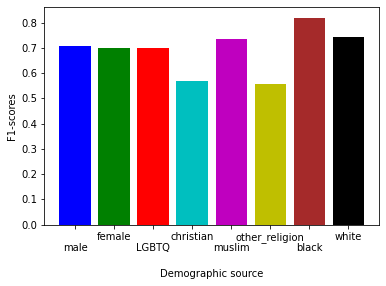

In [11]:
forBarPlot = model.PredictTestSetDemographic(test_data)
print(forBarPlot)
plt.figure()

x = forBarPlot[:,1]
for i in range(len(x)):
    if i%2 == 0:
        x[i] = "\n"+x[i]

y = np.array(forBarPlot[:,0].astype(float))

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color=['b', 'g', 'r', 'c', 'm', 'y', 'brown', 'k'])

plt.xlabel("\nDemographic source")
plt.ylabel("F1-scores")
plt.xticks(x_pos, x)
plt.savefig('FinalF1-scoresFair')
plt.show()

In [12]:
print(np.var(forBarPlot[:,0].astype(float)))
print(np.max(forBarPlot[:,0].astype(float)) - np.min(forBarPlot[:,0].astype(float)))

0.006795419499422311
0.26444444444444437


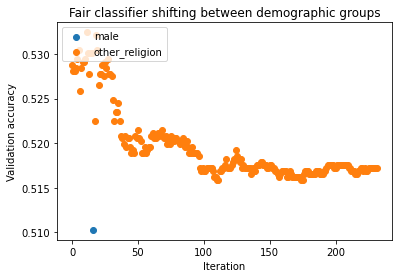

In [13]:
lstlst = []
for k in np.unique(model.FinalAccList_[:,1]):
    tmpLst = []
    for i in model.FinalAccList_:
        if k == i[1]:
            tmpLst.append([i[0], i[2], i[1]])
    lstlst.append(np.array(tmpLst))

plt.figure()
for lst in lstlst:
    plt.scatter(np.array(lst[:,1]).astype(int), np.array(lst[:,0]).astype(np.float), label=lst[:,2][0])

plt.xlabel('Iteration')
plt.ylabel('Validation accuracy')
plt.title('Fair classifier shifting between demographic groups')
plt.legend(loc='upper left')
plt.savefig('AccuracyEvolvingFair')
plt.show()

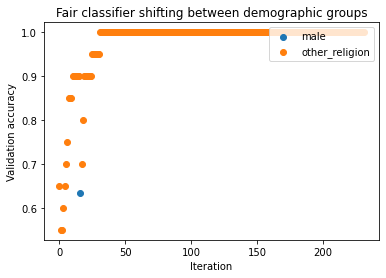

In [14]:
lstlst = []
for k in np.unique(model.FinalAccListTrain_[:,1]):
    tmpLst = []
    for i in model.FinalAccListTrain_:
        if k == i[1]:
            tmpLst.append([i[0], i[2], i[1]])
    lstlst.append(np.array(tmpLst))

plt.figure()
for lst in lstlst:
    plt.scatter(np.array(lst[:,1]).astype(int), np.array(lst[:,0]).astype(np.float), label=lst[:,2][0])

plt.xlabel('Iteration')
plt.ylabel('Validation accuracy')
plt.title('Fair classifier shifting between demographic groups')
plt.legend(loc='upper right')
plt.savefig('AccuracyEvolving')
plt.show()